In [1]:
import ira
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GridSearchCV, GroupKFold
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline

%alphalab dark

from alpha.utils.data_helpers import FriendlyFxLoader, make_forward_returns_matrix

from qlearn.core.pickers import SingleInstrumentPicker, PortfolioPicker
from qlearn.core.forward_returns import ForwardReturns, ForwardReturnsDirection, ForwardReturns3Classes
from qlearn.core.base import BasicMarketEstimator, MarketDataComposer
from qlearn.core.utils import crossup, crossdown, permutate_params

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


In [2]:
fxl = FriendlyFxLoader('dukas @ 5Min')
data = fxl.ohlcs(['EURUSD', 'GBPUSD', 'USDCHF'])
ext = fxl.externals(['EURUSD', 'GBPUSD'])

df1 = scols(*data.values(), keys=data.keys())
df2 = data
df3 = data['EURUSD']

In [3]:
with DataSource('databank_ads::quotes') as ds:
    ticks = ds.load_data(['MT5_PROXY:NDXM', 'MT5_PROXY:ENQ', 'MT5_PROXY:EP'], '2020-11-19 00:00', '2020-12-03 12:00')

<hr/>
<h3>How to iterate through every symbol in market data</h3>
<hr/>

In [3]:
for s, v in SingleInstrumentPicker(timeframe='1d').for_range('2020-03-01').iterate(df1):
    print(s, v)
    print('[red]===================')

<hr/>
<h3>How to iterate through whole portfolio of symbols</h3>
<hr/>

In [ ]:
for s, v in PortfolioPicker(timeframe='1d').iterate(df1):
    print(s)
    print(v)

In [7]:
v

GBPUSD                                            USDCHF  \
                open      high       low     close    volume      open   
time                                                                     
2014-01-01  1.656550  1.659245  1.655980  1.657745    1561.0  0.891710   
2014-01-02  1.657720  1.660340  1.641165  1.644900   71502.0  0.891595   
2014-01-03  1.644910  1.647395  1.639545  1.641865   58463.0  0.899285   
2014-01-05  1.640405  1.641650  1.639955  1.641155    1981.0  0.904975   
2014-01-06  1.641170  1.643390  1.633760  1.641350   59532.0  0.905320   
...              ...       ...       ...       ...       ...       ...   
2020-11-22  1.329490  1.330490  1.328105  1.330370    4302.0  0.911250   
2020-11-23  1.330350  1.339780  1.326390  1.332640   97513.0  0.910660   
2020-11-24  1.332635  1.338050  1.329310  1.336175  100896.0  0.912445   
2020-11-25  1.336185  1.339350  1.330415  1.338340  102676.0  0.910950   
2020-11-26  1.338355  1.339795  1.332215  1.335360   70479.0  0.908200   

                                                     EURUSD            \
                high       low     close   volume      open      high   
time                                                                    
2014-01-01  0.892855  0.891315  0.891575   1690.0  1.375950  1.377350   
2014-01-02  0.902870  0.890875  0.899275  67356.0  1.376600  1.377505   
2014-01-03  0.905785  0.898945  0.905170  49271.0  1.366545  1.367215   
2014-01-05  0.905530  0.904295  0.905325   1597.0  1.359455  1.360060   
2014-01-06  0.907040  0.902025  0.903935  49053.0  1.359575  1.365300   
...              ...       ...       ...      ...       ...       ...   
2020-11-22  0.911515  0.910615  0.910655   2576.0  1.185510  1.186615   
2020-11-23  0.914805  0.907630  0.912490  48958.0  1.186570  1.190610   
2020-11-24  0.913660  0.909790  0.910955  49340.0  1.184245  1.189795   
2020-11-25  0.913915  0.907805  0.908235  57301.0  1.189775  1.192980   
2020-11-26  0.909355  0.906040  0.906550  39572.0  1.191655  1.194095   

                                         
                 low     close   volume  
time                                     
2014-01-01  1.374065  1.376600   2079.0  
2014-01-02  1.362975  1.366545  77624.0  
2014-01-03  1.358240  1.358870  65606.0  
2014-01-05  1.358920  1.359570   1927.0  
2014-01-06  1.357160  1.362975  66351.0  
...              ...       ...      ...  
2020-11-22  1.185445  1.186565   3002.0  
2020-11-23  1.179990  1.184240  90178.0  
2020-11-24  1.183855  1.189755  96170.0  
2020-11-25  1.188190  1.191645  99708.0  
2020-11-26  1.188535  1.191105  63984.0  

[2155 rows x 15 columns]

<hr/>
<h3>Forward returns producers</h3>
<hr/>

In [4]:
print(ForwardReturns(horizon=1, returns_type='pips', tick_size=1e-5).transform(ohlc_resample(df3, '1d'), None))
print(ForwardReturns3Classes(horizon=1, tick_size=1e-5, tick_tolerance=500).transform(ohlc_resample(df3, '1d'), None))

<hr/>
<h3>Simple entry (rsi indicator)</h3>
<hr/>

In [5]:
class RsiEntry(BasicMarketEstimator):
    def __init__(self, period, low=15, up=85):
        self.period = period
        self.low = low
        self.up = up

    def fit(self, X, y, **fit_params):
        return self

    def predict(self, X):
        meta = self.metadata()
        r = rsi(X[meta.column], self.period)
        sigs = pd.Series(0, r.index)
        sigs.loc[crossup(r, self.low)] = +1
        sigs.loc[crossdown(r, self.up)] = -1
        return sigs.astype(int)

In [6]:
m1 = RsiEntry(14, 25, 75)
print(m1.predict(df1.GBPUSD))

<hr/>
<h3>How to attach additional data</h3>
<hr/>

In [7]:
class MidDayCalculator(TransformerMixin):
    def fit(self, x, y, **kwargs):
        return self
    
    def transform(self, x):
        return x.assign(middle = 0.5*(x.low + x.high)).shift(1)

In [8]:
m1 = make_pipeline(MidDayCalculator(), RsiEntry(16, 20, 80))
print(m1.predict(df1.EURUSD))

<hr/>
<h3>Market data composer</h3>
<hr/>

In [11]:
m1 = RsiEntry(10, 20, 80)
c1 = MarketDataComposer(m1, SingleInstrumentPicker(tz='EET'), None, 'close', '1D')

print(c1.fit(df2, None).predict(df2))

In [40]:
m1 = make_pipeline(MidDayCalculator(), RsiEntry(10, 10, 90).as_classifier())

g1 = GridSearchCV(
    cv=TimeSeriesSplit(3),
    estimator = m1,
    param_grid={ 
        'rsientry__period': np.arange(7, 16), 
        'rsientry__low': [10, 20, 25], 
        'rsientry__up': [90, 80, 75], 
    },
)

mds = MarketDataComposer(g1, 
                         SingleInstrumentPicker(tz='EET'), 
                         ForwardReturns3Classes(horizon=1, tick_size=1e-5, tick_tolerance=25), 
                         'close', '5Min', debug=False
                        )

In [41]:
b = mds.fit(df1, None)

In [42]:
b.best_params_

{'GBPUSD': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90},
 'USDCHF': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90},
 'EURUSD': {'rsientry__low': 10, 'rsientry__period': 15, 'rsientry__up': 90}}

In [43]:
b.best_score_

{'GBPUSD': 0.6004638005243638,
 'USDCHF': 0.7636150945544798,
 'EURUSD': 0.7209429313789427}

In [ ]:
b.picker.rules = []
b.predict(df1)
# b.predict(df1[['GBPUSD']])

In [ ]:
b.picker.rules = []
b.predict(df1)
# b.predict(df1[['GBPUSD']])

<hr/>
<h3>Complex strategy with predictors</h3>
<hr/>

In [49]:
class TestComplex(BasicMarketEstimator):
    def __init__(self, period, adx_threshold=15, s1=RsiEntry(10, 20, 80)):
        self.period = period
        self.adx_threshold = adx_threshold
        self.s1 = s1

    def fit(self, X, y, **fit_params):
        meta = self.metadata()
        return self

    def predict(self, X):
        d = adx(X, self.period, smoother='sma', as_frame=True)
        p = self.s1.predict(X)
        
        p[d.ADX < self.adx_threshold] = 0
        p[(p > 0) & (X.middle < X.close)] = 0
        p[(p < 0) & (X.middle > X.close)] = 0
        return p


g1 = GridSearchCV(
        n_jobs=5,
        cv=TimeSeriesSplit(3),
        estimator = make_pipeline(make_pipeline(MidDayCalculator()), TestComplex(10).as_classifier()),
        param_grid = permutate_params({ 
            'testcomplex__period': np.arange(25, 150, 10), 
            'testcomplex__adx_threshold': [10, 15, 20, 25], 
            'testcomplex__s1__period': np.arange(3, 15), 
            'testcomplex__s1__low': [10, 15, 20, 25], 
            'testcomplex__s1__up': [90, 85, 80, 75],
        }, conditions=lambda testcomplex__s1__low, testcomplex__s1__up: testcomplex__s1__low + testcomplex__s1__up==100),
        verbose=1
    )

ms1 = MarketDataComposer(g1, 
                         SingleInstrumentPicker(tz='EET'), 
                         ForwardReturnsDirection(horizon=1), 
                         'close', '1D', debug=False
                        )

In [48]:
b1 = ms1.fit(df1, None)

Fitting 3 folds for each of 2496 candidates, totalling 7488 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 635 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 1635 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 3035 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 4835 tasks      | elapsed:   32.1s
[Parallel(n_jobs=5)]: Done 7035 tasks      | elapsed:   45.0s
[Parallel(n_jobs=5)]: Done 7488 out of 7488 | elapsed:   47.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 3 folds for each of 2496 candidates, totalling 7488 fits


[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 3350 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 6150 tasks      | elapsed:   34.8s
[Parallel(n_jobs=5)]: Done 7479 out of 7488 | elapsed:   42.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 7488 out of 7488 | elapsed:   42.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 3 folds for each of 2496 candidates, totalling 7488 fits


[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 3350 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 6150 tasks      | elapsed:   34.8s
[Parallel(n_jobs=5)]: Done 7479 out of 7488 | elapsed:   42.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 7488 out of 7488 | elapsed:   42.3s finished


In [50]:
b1.best_params_, b1.best_score_

({'GBPUSD': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 25,
   'testcomplex__s1__period': 3,
   'testcomplex__s1__up': 75},
  'USDCHF': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 25,
   'testcomplex__s1__period': 5,
   'testcomplex__s1__up': 75},
  'EURUSD': {'testcomplex__adx_threshold': 10,
   'testcomplex__period': 25,
   'testcomplex__s1__low': 20,
   'testcomplex__s1__period': 3,
   'testcomplex__s1__up': 80}},
 {'GBPUSD': 0.018315018315018316,
  'USDCHF': 0.01391941391941392,
  'EURUSD': 0.011721611721611722})

In [ ]:
p0 = z_test_signals_inplace(shift_signals(b1.predict(df1), hours=23), df2, 'forex', spread=0, verbose=False)
tearsheet(p0, 20000)

<hr/>
<h3>Multi instrument strategy (portfolio)</h3>
<hr/>

In [6]:
import seaborn as sns

In [7]:
sxl = FriendlyFxLoader('nyse @ daily')
md = sxl.ohlcs(sxl.symbols())

In [50]:
class PairsTrader(BasicMarketEstimator):
    def __init__(self, period, z_period, pctls=5, nstd=None):
        self.period = period
        self.z_period = z_period
        self.pctls = pctls
        self.nstd = nstd
        
    def calc_z(self, x, y):
        s = x - y
        m = apply_to_frame(sma, s, self.period)
        ds = s - apply_to_frame(sma, s, self.period)
        return ds / ds.rolling(window=self.z_period, min_periods=self.z_period).std()

    def fit(self, X, y, **fit_params):
        s1, s2, *_ = self.metadata().symbols
        closes = X.xs('close', axis=1, level=1)
        zs = self.calc_z(closes[s1], closes[s2])
        if self.nstd is None:
            self.zb_, self.zt_ = np.percentile(zs.dropna(), sorted([self.pctls, 100-self.pctls]))
        else:
            self.zb_, self.zt_ = self.nstd, -self.nstd
        print(self.zb_, self.zt_)
        
        return self

    def predict(self, X):
        s1, s2, *_ = self.metadata().symbols
        closes = X.xs('close', axis=1, level=1)
        
        zs = self.calc_z(closes[s1], closes[s2])
        s_entries = crossdown(zs, self.zt_)
        l_entries = crossup(zs, self.zb_)
        
        short_spread = pd.DataFrame({s1: -1, s2: +1 }, s_entries)
        short_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossdown(zs, 0.5))
        
        long_spread = pd.DataFrame({s1: +1, s2: -1 }, l_entries)
        long_ex = None #pd.DataFrame({s1: 0, s2: 0 }, crossup(zs, -0.5))
        
        plt.plot(zs); plt.plot(zs.loc[s_entries], 'r.', ms=4);  plt.plot(zs.loc[l_entries], 'g.', ms=4)
        plt.axhline(self.zt_); plt.axhline(self.zb_)
        
        return srows(long_spread, long_ex, short_spread, short_ex).sort_index()

In [62]:
p_trader = PairsTrader(5, 20, 5)

fm = MarketDataComposer(p_trader, PortfolioPicker(['DHI$', 'PHM$']).for_range('2006'), None, 'close').fit(md, pd.Series(0))

Statistic,Model
Gain (USD):,65630.00
CAGR (%):,10.161
Sharpe:,0.782
Sortino:,1.195
Calmar:,0.495
MaxDD (%):,17.313
MaxDD On Init BP (%):,47.100
MaxDD (USD):,9420.000
MaxDD days:,220 days
MaxDD start:,2017-09-12

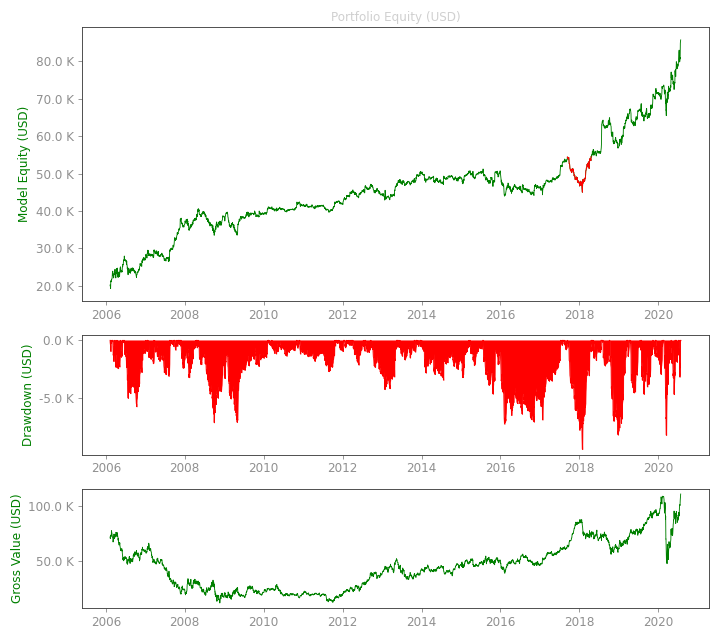

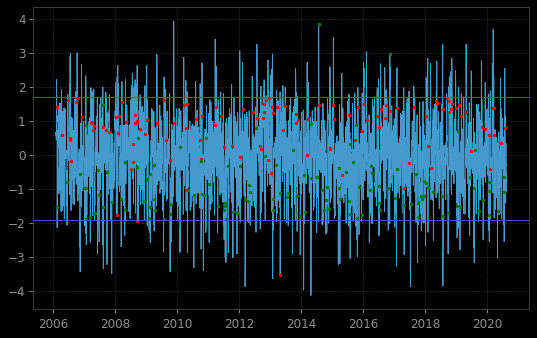

<Figure size 720x640 with 0 Axes>

In [63]:
p0 = z_test_signals_inplace(1000*fm.predict(md), md, 'stock', spread=0.1, verbose=False)
tearsheet(p0, 20000)

In [307]:
c_table = mc.corr()